# Non-parametric regression 

We consider a regression model $Y=h(X)+E$ where $(X,Y)$ are the observations, $E$ is a gaussian noise and $h$ is the function we want to learn. We assume that $h$ is a continuous function such that $h(0)=0$ and that the support of the distribution of $X$ is included in $[0,1]$. 

We set $L(h)$ as the squared loss associated to the model (i.e $L(h) = \mathbb{E}(Y-h(X))^2$ ).

We can thus compute the Malliavin Gradient of $L$ with respect to $h$ as: $$\nabla L (h) (.) = \mathbb{E}\Biggl[ 2(Y-h(X)) \min(.,X) \Biggr] \ .$$

Theoretically, we have now all the tools to perform a simple gradient descent to learn $h$. If we denote by $(X_i,Y_i)_{i=1,..,n}$ our training sample, then the gradient descent update takes the form: 
$$ h^{t+1}(.) = h^t(.) - 2 \alpha \frac{1}{n} \sum_{i}(Y_i-h^t(X_i)) \min(.,X_i) \ ,$$ 
where $\alpha$ is the stepsize. 

The question now is : How do we compute it? We can't simply discretize the interval $[0,1]$ and learn the function in the points of the discretization, because doing so, we may not be able to compute the value $h(X)$ unless the value of $X$ falls into the discretization.

We offer here a true computation of the gradient descent above. That is, after T iterations, the function we plot is exactly $h^T$. The idea is to first compute the table $\{h^{t}(X_i)\}_{i \in [1,n], t \in [1,T]}$. Then, by a telescoping series argument, we have
$$ h^T(.) = h^0(.) - 2 \alpha \sum_{t=1,..,T} \frac{1}{n} \sum_{i} (Y_i - h^t(X_i)) \min(.,X_i) \ .$$

Anyhow, we used here the squared loss which gradient can be easily computed. However, for general losses, one can imagine a gradient that is not explicitly known or too coslty to be computed. In this case, referring to Malliavin Calculus, one can compute an unbiased estimate of the gradient using only the loss itself: 
$$ \hat{\nabla L} (h) (.) = \frac{1}{\gamma} L(h(X)+ \gamma B_X) B(.) \ ,$$
where $\gamma$ is a smoothing parameter.

Therefore, we can now perform the gradient-free SGD:
$$h^{t+1}(.) = h^t(.) -  \frac{\alpha}{\gamma} \frac{1}{n} \sum_{i} L(h^t(X_i)+ \gamma B^t_{X_i}) B^t(.) \ ,$$
which can be implemented exactly using the same argument as before.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
from tqdm import tqdm
from math import *
from sklearn import neighbors
import scipy
from scipy import stats
import numpy as np

In [72]:
[1, 2, 3][:-1]

[1, 2]

A Brownian Motion function 

In [111]:
def brownian(X, n_samples=100, seed=42):
    """
    Returns one trajectory of a brownian motion which can be evaluated on a specified set of points
    """
    X = np.sort(X)
    if 0 not in X:
        X = np.concatenate(([0], X))
        
    n = len(X)  
    sample_values = np.zeros((n, n_samples))
    steps = X[1:] - X[:-1]
    np.random.seed(seed)
    for i, dt in enumerate(steps):
        sample_values[i + 1] = sample_values[i] + sqrt(dt) * np.random.randn(n_samples)
    np.random.seed()
    def sample_eval(t):
        if t in X:
            idx = list(X).index(t)
            return sample_values[idx]
        else:
            raise ValueError("Brownian motion was not sampled at that point")
    return sample_eval

In [88]:
a = brownian(np.linspace(0, 1, 1000), 2)

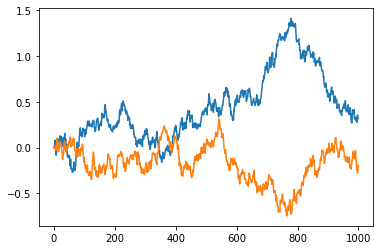

In [89]:
plt.plot([a(k)[0] for k in np.linspace(0, 1, 1000)])
plt.plot([a(k)[1] for k in np.linspace(0, 1, 1000)])
plt.show()

We define here our the function we want to learn, which we call payoff

In [41]:
def d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T) + 1e-6)


def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)


def call(S, K, T, r, sigma):
    cdf = stats.norm(0, 1).cdf
    return S * cdf(d1(S, K, T, r, sigma)) - K * np.exp(-r * T) * cdf(d2(S, K, T, r, sigma))

S = 100
TT = 1
K = 100
r = 0.05
Sigma = 10
a = call(S, K, TT, r, 0.2*Sigma)
b = call(S, K, TT, r, 0.8*Sigma)
def ind(sigma):
    return np.where(sigma >= 0, 1, 0)
def payoff(sigma):
    #if sigma < 0.2:
    #    return (a/0.2)*(sigma)
    #if sigma > 0.8:
    #    return b
    #else:
    
    # return call(S,K,TT,r,sigma*Sigma) - call(S,K,TT,r,0) 
    return np.sin(2*pi * sigma)

payoff plot

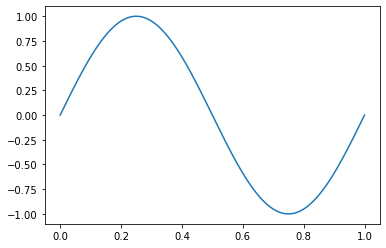

In [42]:
from scipy.misc import derivative
t = np.linspace(0,1,1000)
plt.plot(t, payoff(t))
#y = [derivative(payoff, x, dx = 1e-6) for x in t ]
#plt.plot(t,y)
plt.show()

In [43]:
def generate_data(n, noise_var=10, show=False):
    #X = np.random.triangular(0, 1, 1, size=n)
    X = np.random.uniform(0, 1, n)
    
    # the independant noise
    E = np.random.normal(0, noise_var, n)
    Y = payoff(X) + E
    
    if show:
        plt.figure()
        plt.scatter(X, Y)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()
    return X, Y

Here's the noisy training data for our regression model

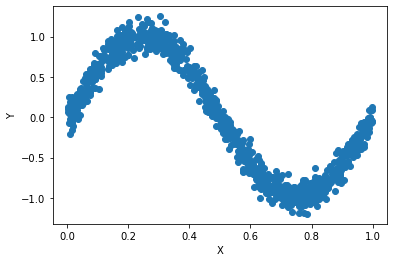

In [44]:
#Sample:
n_train = 1000
noise_variance = 0.1
X_train, Y_train = generate_data(n_train, noise_var=noise_variance, show=True)

In [45]:
def f0(sigma):
    # the identity function is our initialization
    return sigma

In [46]:
def h2_phi(t,x):
    term1 = - np.sinh(np.minimum(x,t) - t)
    term2 = - np.sinh(t) + np.cosh(t) * np.minimum(x,t)
    term3 =  - np.sinh(t) * (np.cosh(x) - 1) + np.sinh(t) * np.sinh(x) / np.sinh(1)
    return  term1 + term2 + term3

In [47]:
def h3_phi(x,t):
    """
    Expression not complete
    """
    return np.exp(x-t)/3 - (np.exp(-(x-t)/2)/3)*(np.cos(sqrt(3)*(x-t)/2) + sqrt(3)*np.sin(sqrt(3)*(x-t)/2))

$$\nabla L (h) (.) = \mathbb{E}\Biggl[ 2(Y-h(X)) \min(.,X) \Biggr] .$$

$$h^{t+1}(.) = h^t(.) -  \frac{\alpha}{\gamma} \frac{1}{n} \sum_{i} L(h^t(X_i)+ \gamma B^t_{X_i}) B^t(.) \ ,$$

In [138]:
def gradient_free_descent(X_train, X_test, Y_train, f0, gamma, n_iter=1000, step=0.05, n_brownians=100, 
                          seeds=[42]):
    assert len(seeds) == n_iter
    n = len(X_train)
    F = np.zeros((n_iter,n))
    F[0, :] = f0(X_train)
    
    # Why n steps for n points?
    for i in tqdm(range(1, n_iter)):
        brownian_motions = brownian(np.concatenate((X_train, X_test)), n_brownians, seed=seeds[i])
        bs = np.array([brownian_motions(x) for x in X_train])
        for j in range(n): 
            F[i,j] = F[i-1,j] - (step / gamma) * np.mean((F[i-1, :][:, np.newaxis] + gamma * bs - Y_train[:, np.newaxis]) * brownian_motions(X_train[j])[np.newaxis, :])
    return F

def gradient_free_f(x, X_test, F_train, f0, X_train, Y_train, gamma, step=0.05, n_brownians=100, seeds=[42]):
    """
    Applying the learnt function to points outside the training sample
    """
    n_iter = F_train.shape[0]
    assert len(seeds) == n_iter
    _sum = 0
    for j in tqdm(range(n_iter - 1)): 
        brownian_motions = brownian(np.concatenate((X_train, X_test)), n_brownians, seed=seeds[j])
        bs = np.array([brownian_motions(x_tr) for x_tr in X_train])
        _sum += (step / gamma) * np.mean((F_train[j,:][:, np.newaxis] + gamma * bs - Y_train[:, np.newaxis]) * brownian_motions(x)[np.newaxis, :])
    res = f0(x) - _sum
    return res

In [139]:
def gradient_descent(X_train, Y_train, f0, sobolev_idx, n_iter=1000, step=0.05):
    """
    Learning the function in the training sample points
    """
    n = len(X_train)
    F = np.zeros((n_iter,n))
    F[0, :] = f0(X_train)
    if sobolev_idx == 1:
        phi = np.minimum
    elif sobolev_idx == 2:
        phi = h2_phi
    
    # Why n steps for n points?
    for i in tqdm(range(1, n_iter)):
        for j in range(n):
            F[i,j] = F[i-1,j] - 2 * step * np.mean((F[i-1,:] - Y_train) * phi(X_train, X_train[j]))
    return F

def f(x, F_train, f0, X_train, Y_train, sobolev_idx, n_iter, step=0.05):
    """
    Applying the learnt function to points outside the training sample
    """
    if sobolev_idx == 1:
        phi = np.minimum
    elif sobolev_idx == 2:
        phi = h2_phi
        
    a = [np.mean(2 * step * (F_train[j, :] - Y_train) * phi(X_train, x)) 
         for j in range(n_iter - 1)]
    _sum = sum(a)
    res = f0(x) - _sum
    return res

In [140]:
# Run the gradient descent
step1 = 0.1
step2 = 0.5
n_iter = 1000
n_test = 100

X_test = np.linspace(0, 1, n_test)

In [ ]:
F_train_h1 = gradient_descent(X_train, Y_train, f0, 1, n_iter, step1)
y_pred_test_h1 = np.array([f(x, F_train_h1, f0, X_train, Y_train, 1, n_iter, step1) for x in X_test])

F_train_h2 = gradient_descent(X_train, Y_train, f0, 2, n_iter, step1)
y_pred_test_h2 = np.array([f(x, F_train_h2, f0, X_train, Y_train, 2, n_iter, step2) for x in X_test])

In [141]:
seeds = np.random.randint(100000000, size=n_iter)
gamma = 1/np.sqrt(n_train)
F_train_gfree = gradient_free_descent(X_train, X_test, Y_train, f0, gamma, n_iter, step1, n_brownians=2, seeds=seeds)
y_pred_test_gfree = np.array([gradient_free_f(x, X_test, F_train_gfree, f0, X_train, Y_train, gamma, step1, 
                                              n_brownians=2, seeds=seeds)
                           for x in X_test])

  3%|▎         | 34/999 [00:07<03:30,  4.58it/s]


KeyboardInterrupt: 

Run a KNN regressor on the same data for comparison

In [66]:
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights="distance")
knn_pred_y_test = knn.fit(X_train.reshape((-1, 1)), Y_train).predict(X_test.reshape((-1, 1)))

Compare the results of both regressions to the ground truth

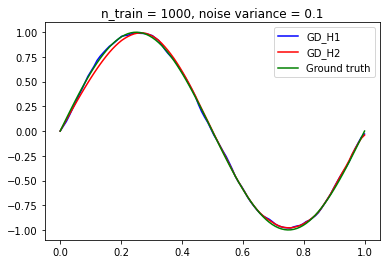

In [96]:
x_order = np.argsort(X_test)
plt.title("n_train = {}, noise variance = {}".format(n_train, noise_variance))

sorted_X_test = np.sort(X_test)
#plt.plot(sorted_X_test, knn_pred_y_test[x_order], label='KNN', color='r')
plt.plot(sorted_X_test, y_pred_test_h1[x_order], label='GD_H1', color='b')
plt.plot(sorted_X_test, y_pred_test_h2[x_order], label='GD_H2', color='r')
plt.plot(sorted_X_test, y_pred_test_gfree[x_order], label='GD_free', color='black')
plt.plot(sorted_X_test, payoff(sorted_X_test), label='Ground truth', color='g')
plt.legend()
plt.show()

Comparison of the derivatives

In [97]:
from scipy.misc import derivative
y_pred_deriv_h1 = [derivative(f, x, dx = 1e-6, args=(F_train_h1,f0,X_train,Y_train,1,n_iter, step)) 
                   for x in tqdm(sorted_X_test) ]
y_pred_deriv_h2 = [derivative(f, x, dx = 1e-6, args=(F_train_h2,f0,X_train,Y_train,2,n_iter, step)) 
                   for x in tqdm(sorted_X_test) ]
y = [derivative(payoff, x, dx = 1e-6) for x in sorted_X_test]

 62%|██████▏   | 62/100 [04:05<02:30,  3.96s/it]

KeyboardInterrupt: 

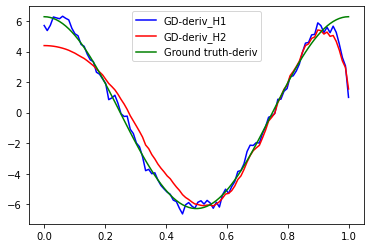

In [54]:
plt.plot(sorted_X_test,y_pred_deriv_h1, label='GD-deriv_H1', color='b')
plt.plot(sorted_X_test,y_pred_deriv_h2, label='GD-deriv_H2', color='r')
plt.plot(sorted_X_test,y, label='Ground truth-deriv', color='g')
plt.legend()
plt.show()

In [13]:
print("The L2 loss for the H1 gradient descent on test split is: {:.3f}".format(np.linalg.norm(payoff(sorted_X_test), 
                                                                                               y_pred_test_h1[x_order])))
print("The L2 loss for the H2 gradient descent on test split is: {:.3f}".format(np.linalg.norm(payoff(sorted_X_test), 
                                                                                               y_pred_test_h2[x_order])))

100

Comparison of the losses on the test sample

Plot of the training loss

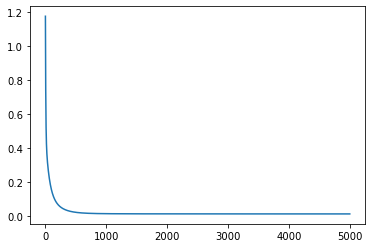

In [15]:
loss_train = np.mean((F_train - Y_train.reshape((1, -1)))**2, axis=1)

plt.figure()
plt.plot(loss_train)
plt.show()

Comparison of three distributions with fixed sample size and number of iterations

In [16]:
#X = uniform distribution
#X = triangular distribution (0,0.8,1)
#X= triangular distribution (0,1,1)
#Compare these distributions to see how the behavior at the end changes

# Non-parametric regression in higher dimension

We consider a regression model $Y=h(X)+E$ where $(X,Y)$ are the observations, $E$ is a gaussian noise and $h$ is the function we want to learn. We assume that $h$ is a continuous function that belongs to the space
$$H = \{g, \ g(t) = \int_0^{t_1} \int_0^{t_d} g'(s) d s, \ g' \in L^2([0,1]^d)$$ and that the support of the distribution of $X$ is included in $[0,1]^d$. 

We set $L(h)$ as the squared loss associated to the model (i.e $L(h) = \mathbb{E}(Y-h(X))^2$ ).

We can thus compute the Malliavin Gradient of $L$ with respect to $h$ as: $$\nabla L (h) (.) = \mathbb{E}\Biggl[ 2(Y-h(X)) \Phi(.,X) \Biggr] \ .$$

Define the kernel functions for all $t \in [0,1]^d$ as $$\Phi_t(.) = \Pi_{k=1}^d (._k \wedge t_k).$$ 

Theoretically, we have now all the tools to perform a simple gradient descent to learn $h$. 
If we denote by $(X_i,Y_i)_{i=1,..,n}$ our training sample, then the gradient descent update takes the form: 
$$ h^{t+1}(.) = h^t(.) - 2 \alpha \frac{1}{n} \sum_{i}(Y_i-h^t(X_i)) \Phi_{X_i}(.) \ ,$$ 
where $\alpha$ is the stepsize. 

Again, the idea is to first compute the table $\{h^{t}(X_i)\}_{i \in [1,n], t \in [1,T]}$. Then, by a telescoping series argument, we have
$$ h^T(.) = h^0(.) - 2 \alpha \sum_{t=1,..,T} \frac{1}{n} \sum_{i} (Y_i - h^t(X_i)) \Phi_{X_i}(.) \ .$$

For general losses, referring to Malliavin Calculus, one can compute an unbiased estimate of the gradient using only the loss itself and a Brownian sheet $B$
$$ \hat{\nabla L} (h) (.) = \frac{1}{\gamma} L(h(X)+ \gamma B_X) B(.) \ ,$$
where $\gamma$ is a smoothing parameter.

Therefore, we can now perform the gradient-free SGD:
$$h^{t+1}(.) = h^t(.) -  \frac{\alpha}{\gamma} \frac{1}{n} \sum_{i} L(h^t(X_i)+ \gamma B^t_{X_i}) B^t(.) \ ,$$
which can be implemented exactly using the same argument as before.